# 2021 빅콘테스트, HTS 데이터를 이용한 Barrel 기준 분석
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import time, os

#from multiprocessing import Manager
#from concurrent.futures import ProcessPoolExecutor as PPE

# If use jupyter-notebook and didn't see a matplotlib graph, run below code.
#%matplotlib inline

## 함수

In [2]:
def getAVG(df):
    if len(df) == 0:
        return -1
    # 1루타, 2루타, 3루타, 번트안타, 홈런
    isHit = [0,1,2,3,14]
    H = len(df[df.HIT_RESULT.isin(isHit)])
    AB = len(df)
    return H / AB

def getSLG(df):
    if len(df) == 0:
        return -1
    H1 = len(df[df.HIT_RESULT.isin([0,3,6])])
    H2 = len(df[df.HIT_RESULT == 1])
    H3 = len(df[df.HIT_RESULT == 2])
    HR = len(df[df.HIT_RESULT == 14])
    AB = len(df)
    return (H1 + 2*H2 + 3*H3 + 4*HR) / AB

## 데이터 로드

In [3]:
origin = pd.DataFrame()
for n in range(4):
    origin = origin.append(pd.read_csv(f'./data/2021_BigContest_KBO_HTS_{2018 + n}.csv', encoding='CP949', thousands=','))
print(f'HTS data count = {len(origin)}')

HTS data count = 120745


## "HIT_RESULT" 라벨링

In [4]:
labels = np.array(['1루타', '2루타', '3루타', '내야안타(1루타)', '땅볼아웃', 
                   '번트아웃', '번트안타', '병살타', '삼중살타', '야수선택', 
                   '인필드플라이', '직선타', '파울플라이', '플라이', '홈런', 
                   '희생번트', '희생플라이'])
encoder = LabelEncoder()
for label in encoder.fit_transform(labels):
    origin['HIT_RESULT'].replace(labels[label], label, inplace=True)

print(origin.describe())

               GYEAR          PCODE            INN        HIT_VEL  \
count  120745.000000  120745.000000  120745.000000  120745.000000   
mean     2019.293188   69753.281916       4.935070     133.732175   
std         1.041636    7388.967977       2.585468      21.337877   
min      2018.000000   50054.000000       1.000000       9.880000   
25%      2018.000000   63963.000000       3.000000     121.680000   
50%      2019.000000   69209.000000       5.000000     137.700000   
75%      2020.000000   76313.000000       7.000000     149.480000   
max      2021.000000   99810.000000      12.000000     210.130000   

         HIT_ANG_VER     HIT_RESULT       PIT_VEL  
count  120745.000000  120745.000000  120745.00000  
mean       17.394404       6.676318     135.79528  
std        24.100255       5.649201       9.21249  
min       -68.900000       0.000000      82.50000  
25%        -1.500000       1.000000     129.60000  
50%        14.500000       4.000000     137.49000  
75%        32.

## HIT_VEL, HIT_ANG_VER 데이터 분포 확인

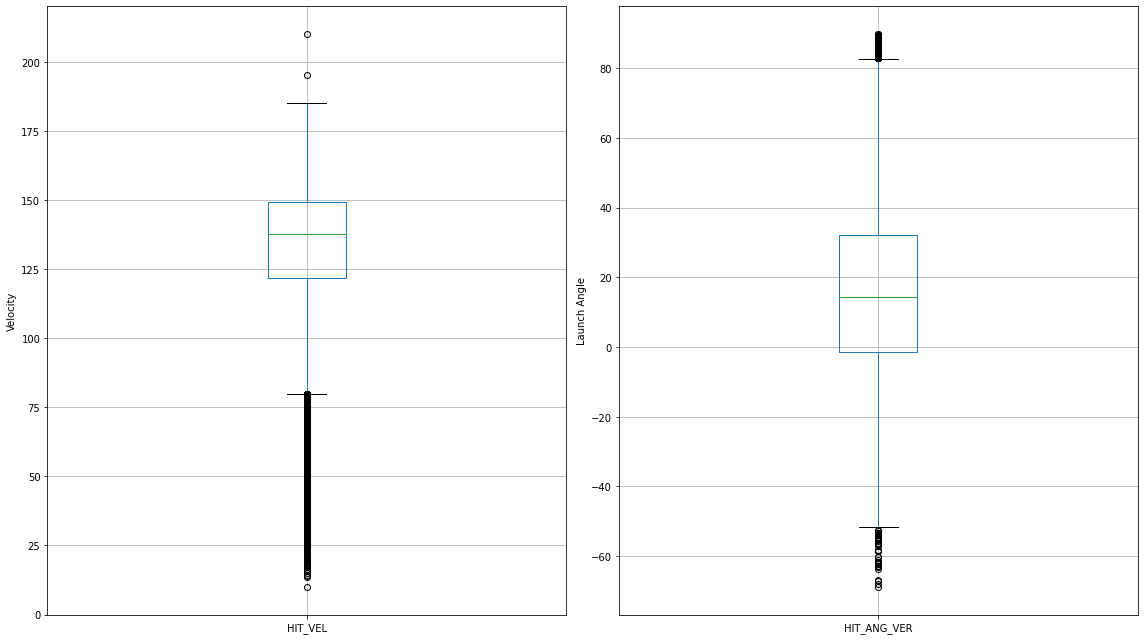

In [5]:
fig = plt.figure(figsize=(16,9))
fig.add_subplot(121)
origin.boxplot(['HIT_VEL'])
plt.ylabel('Velocity')
fig.add_subplot(122)
origin.boxplot(['HIT_ANG_VER'])
plt.ylabel('Launch Angle')
plt.tight_layout()
plt.savefig('./figrue_VEL-ANG_boxplot_origin.png')
plt.show()

## 데이터 전처리
- HIT_ANG_VER를 (-40, 80) 구간으로 추출한 다음, HIT_VEL의 이상치를 다시 필터링
- HIT_ANG_VER (-40, 80) 구간이 대체로 원본 데이터의 1.5\*IQR 이내에 들어감

In [6]:
IQR = origin.quantile(.75) - origin.quantile(.25)
# Select HIT_ANG_VER between(-40, 80) : most are within 1.5*IQR
dfHTS = origin[origin.HIT_ANG_VER.between(-40, 80)].copy()
# Select HIT_VEL within 1.5*IQR
dfHTS = dfHTS[dfHTS.HIT_VEL.between(dfHTS.HIT_VEL.quantile(.25) - (1.5*IQR.HIT_VEL),
                                    dfHTS.HIT_VEL.quantile(.75) + (1.5*IQR.HIT_VEL))]
print(f'Preprocessed HTS data count = {len(dfHTS)}')
print(f'Preprocessed HTS data ratio = {round(len(dfHTS)/len(origin), 4)}')
print()
print(dfHTS.describe())

Preprocessed HTS data count = 117243
Preprocessed HTS data ratio = 0.971

               GYEAR          PCODE            INN        HIT_VEL  \
count  117243.000000  117243.000000  117243.000000  117243.000000   
mean     2019.303353   69762.300223       4.932772     135.380091   
std         1.039557    7394.712163       2.585209      18.840212   
min      2018.000000   50054.000000       1.000000      80.450000   
25%      2018.000000   63963.000000       3.000000     123.340000   
50%      2019.000000   69209.000000       5.000000     138.440000   
75%      2020.000000   76313.000000       7.000000     149.830000   
max      2021.000000   99810.000000      12.000000     185.050000   

         HIT_ANG_VER     HIT_RESULT        PIT_VEL  
count  117243.000000  117243.000000  117243.000000  
mean       17.074650       6.610177     135.779702  
std        23.026925       5.670424       9.214084  
min       -39.900000       0.000000      82.500000  
25%        -1.300000       1.000000    

## HIT_VEL, HIT_ANG_VER 데이터 분포 확인 (dfHTS)

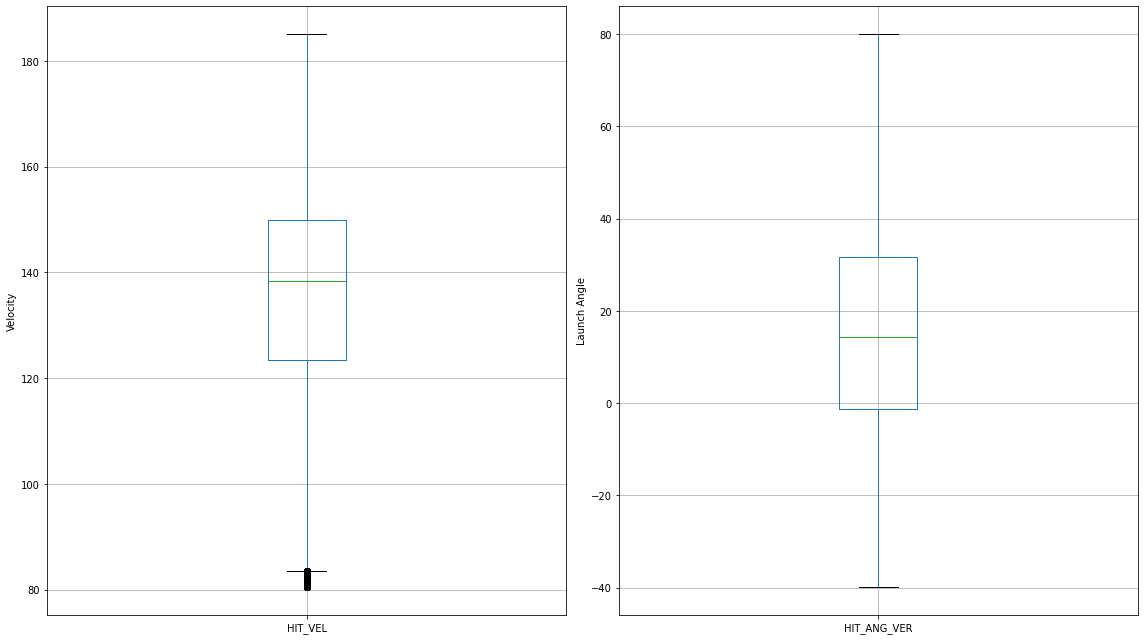

In [7]:
fig = plt.figure(figsize=(16,9))
fig.add_subplot(121)
dfHTS.boxplot(['HIT_VEL'])
plt.ylabel('Velocity')
fig.add_subplot(122)
dfHTS.boxplot(['HIT_ANG_VER'])
plt.ylabel('Launch Angle')
plt.tight_layout()
plt.savefig('./figrue_VEL-ANG_boxplot.png')
plt.show()

## 발사각도 - AVG, SLG, AVG+SLG, 발사각도별 평균 타구속도 확인

In [8]:
ang_unit = 2
ang_range = np.arange(-40, 80, ang_unit)

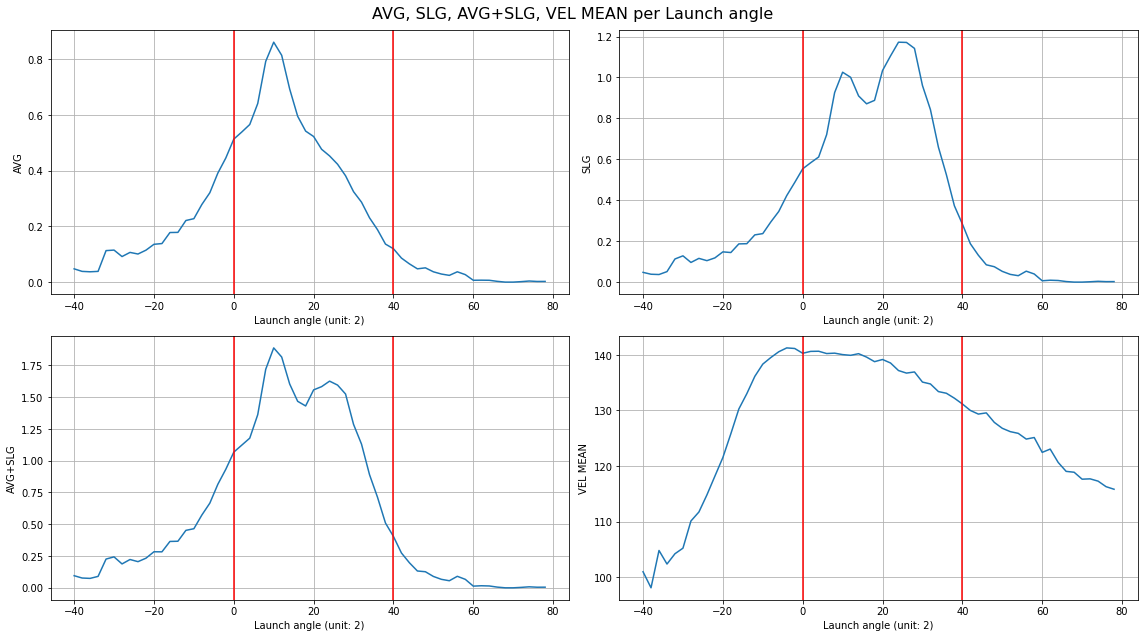

In [9]:
AVG, SLG, AVG_SLG, VEL_MEAN = [], [], [], []
for a in ang_range:
    df = dfHTS[dfHTS.HIT_ANG_VER.between(a, a+ang_unit, 'left')]
    AVG.append(getAVG(df))
    SLG.append(getSLG(df))
    AVG_SLG.append(getAVG(df) + getSLG(df))
    VEL_MEAN.append(df.HIT_VEL.mean())
fig = plt.figure(figsize=(16,9))
axes = [fig.add_subplot(2,2,i) for i in range(1, 5)]
[axes[i].plot(ang_range, data) for i, data in enumerate([AVG, SLG, AVG_SLG, VEL_MEAN])]
fig.suptitle('AVG, SLG, AVG+SLG, VEL MEAN per Launch angle', fontsize=16)
[ax.set_xlabel(f'Launch angle (unit: {ang_unit})') for ax in axes]
[axes[i].set_ylabel(label) for i, label in enumerate(['AVG', 'SLG', 'AVG+SLG', 'VEL MEAN'])]
[ax.grid() for ax in axes]
[ax.axvline(0, color='r') for ax in axes]
[ax.axvline(40, color='r') for ax in axes]
plt.tight_layout()
plt.savefig('./figure_analyze_1.png')
plt.show()

## 발사각도-타구속도 추가 분석
- 타구속도 구간화를 위한 분석

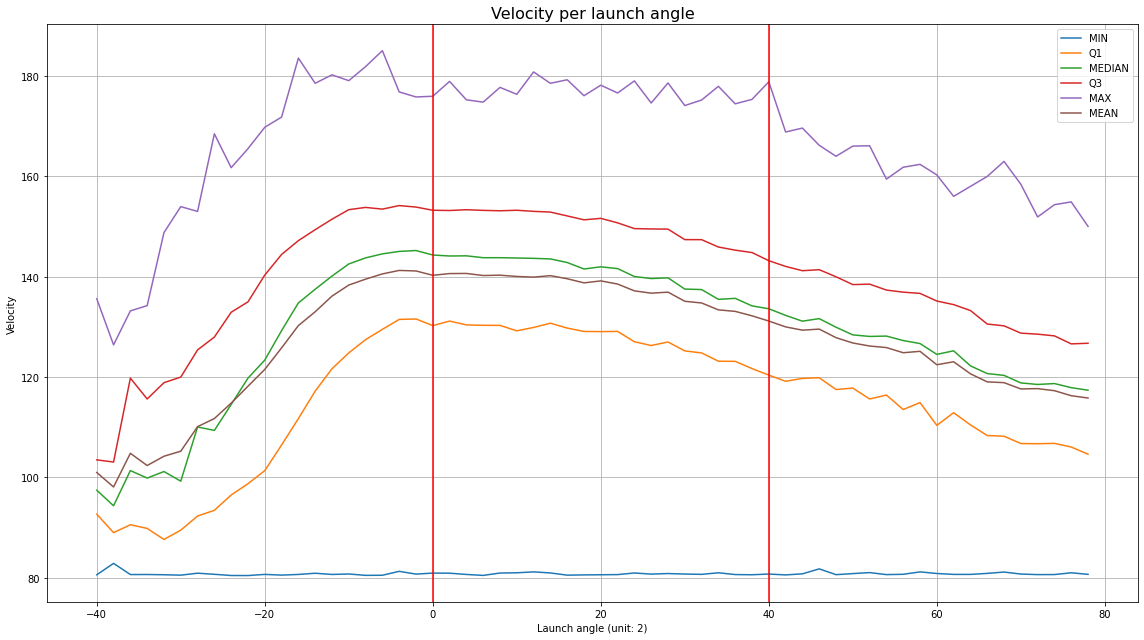

In [10]:
dfVEL = pd.DataFrame()
for a in ang_range:
    df_vel = dfHTS[dfHTS.HIT_ANG_VER.between(a, a+ang_unit, 'left')].HIT_VEL
    df = pd.DataFrame([[df_vel.min(), df_vel.quantile(.25), df_vel.median(), df_vel.quantile(.75), df_vel.max(), df_vel.mean()]],
                      columns='MIN,Q1,MEDIAN,Q3,MAX,MEAN'.split(','))
    dfVEL = dfVEL.append(df)

fig = plt.figure(figsize=(16,9))
plt.title('Velocity per launch angle', fontsize=16)
plt.xlabel(f'Launch angle (unit: {ang_unit})')
plt.ylabel('Velocity')
for col in dfVEL.columns:
    plt.plot(ang_range, dfVEL[col])
plt.legend(dfVEL.columns)
plt.grid()
plt.axvline(0, color='r')
plt.axvline(40, color='r')
plt.tight_layout()
plt.savefig('./figure_velocity-per-angle.png')
plt.show()

- 0~40도 사이 데이터를 기준으로, 타구속도를 3구간화
- 구간별 AVG, SLG, AVG+SLG 확인

In [11]:
tmp = pd.DataFrame()
for a in ang_range:
    if not a in range(0, 40):
        continue
    df_vel = dfHTS[dfHTS.HIT_ANG_VER.between(a, a+ang_unit, 'left')].HIT_VEL
    df = pd.DataFrame([[df_vel.min(), df_vel.quantile(.25), df_vel.median(), df_vel.quantile(.75), df_vel.max(), df_vel.mean()]],
                      columns='MIN,Q1,MEDIAN,Q3,MAX,MEAN'.split(','))
    tmp = tmp.append(df)

#vel_pivot = tuple(map(lambda x: int(x), (round(tmp.MEAN.mean(), 0), round(tmp.Q3.mean(), 0))))
vel_pivot = tuple(map(lambda x: int(x), (round(tmp.Q3.mean(), 0), round((tmp.Q3.mean() + tmp.MAX.mean())/2, 0))))
print(vel_pivot)

df1 = dfHTS[dfHTS.HIT_VEL < vel_pivot[0]]
df2 = dfHTS[dfHTS.HIT_VEL >= vel_pivot[0]]
df3 = dfHTS[dfHTS.HIT_VEL >= vel_pivot[1]]

AVGs = []
SLGs = []
AVG_SLGs = []
for df in [df1, df2, df3]:
    AVG, SLG, AVG_SLG = [], [], []
    for a in ang_range:
        avg = getAVG(df[df.HIT_ANG_VER.between(a, a+ang_unit, 'left')])
        slg = getSLG(df[df.HIT_ANG_VER.between(a, a+ang_unit, 'left')])
        avg_slg = avg + slg
        AVG.append(avg)
        SLG.append(slg)
        AVG_SLG.append(avg_slg)
    AVGs.append(AVG)
    SLGs.append(SLG)
    AVG_SLGs.append(AVG_SLG)


(151, 164)


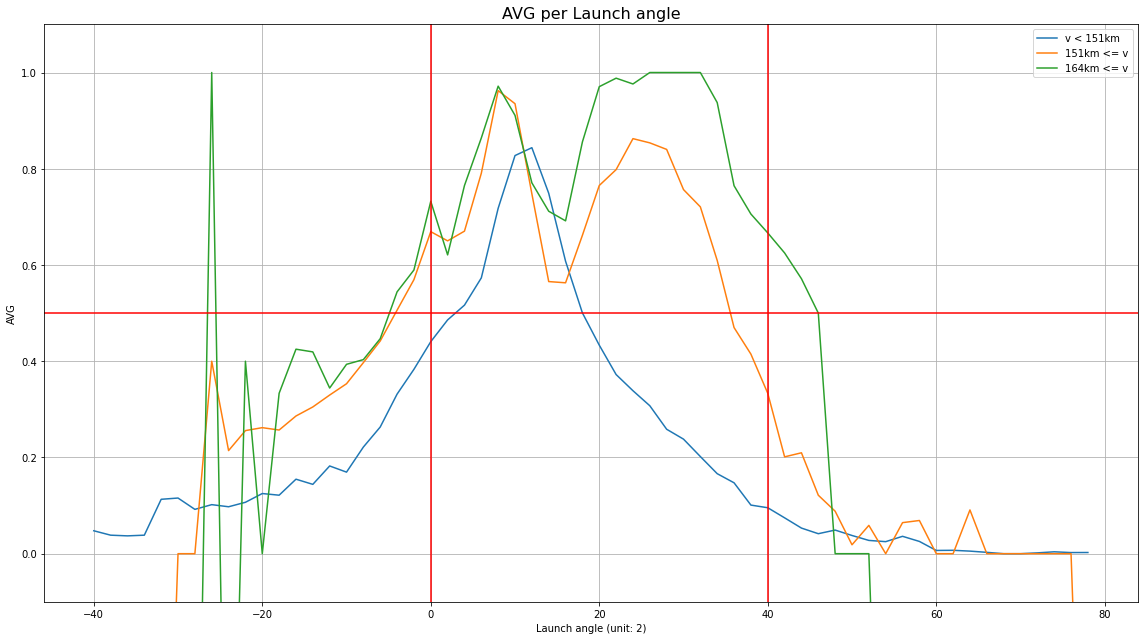

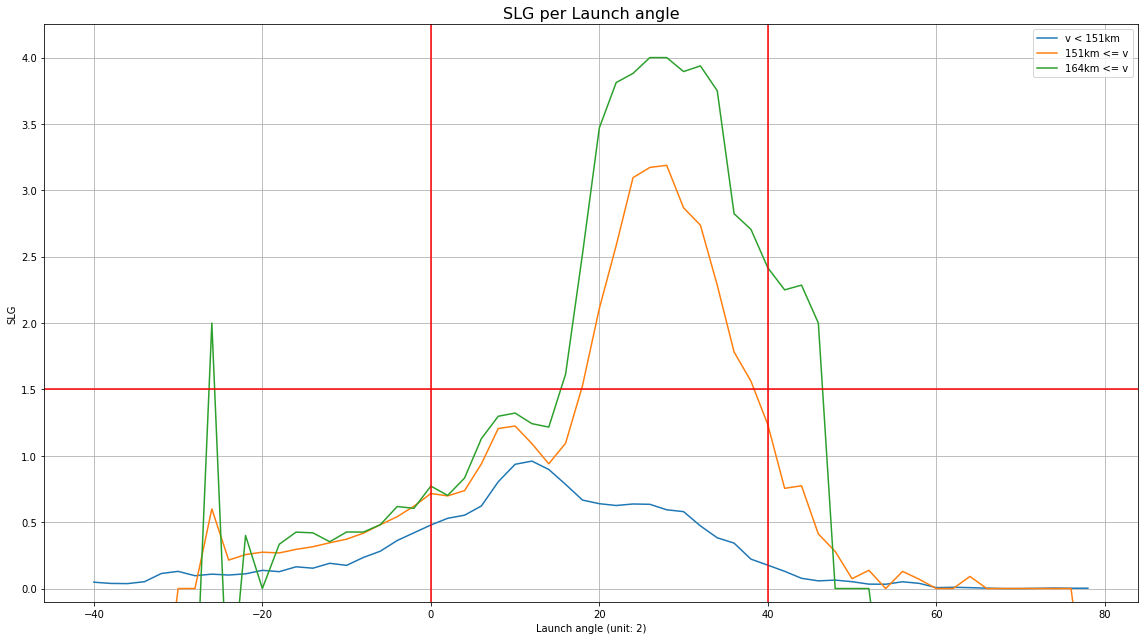

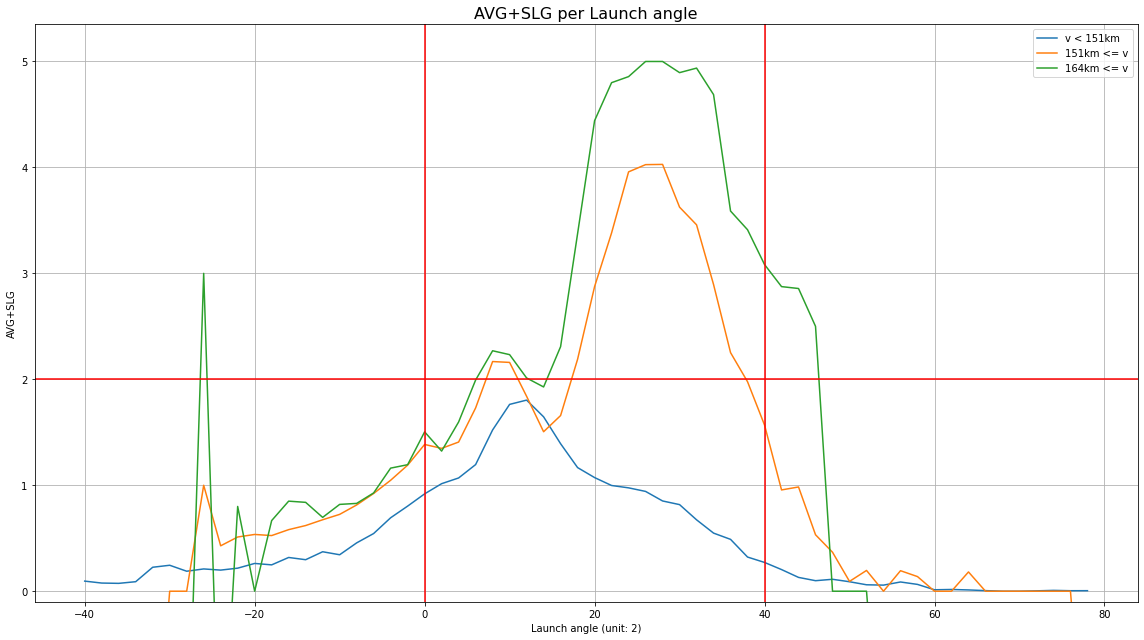

In [12]:
fig = plt.figure(figsize=(16,9))
[plt.plot(ang_range, avg) for avg in AVGs]
plt.legend(f'v < {vel_pivot[0]}km,{vel_pivot[0]}km <= v,{vel_pivot[1]}km <= v'.split(','))
plt.title('AVG per Launch angle', fontsize=16)
plt.xlabel(f'Launch angle (unit: {ang_unit})')
plt.ylabel('AVG')
plt.axvline(0, color='r')
plt.axvline(40, color='r')
plt.axhline(0.5, color='r')
plt.ylim(bottom=-0.1)
plt.grid()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(16,9))
[plt.plot(ang_range, slg) for slg in SLGs]
plt.legend(f'v < {vel_pivot[0]}km,{vel_pivot[0]}km <= v,{vel_pivot[1]}km <= v'.split(','))
plt.title('SLG per Launch angle', fontsize=16)
plt.xlabel(f'Launch angle (unit: {ang_unit})')
plt.ylabel('SLG')
plt.axvline(0, color='r')
plt.axvline(40, color='r')
plt.axhline(1.5, color='r')
plt.ylim(bottom=-0.1)
plt.grid()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(16,9))
[plt.plot(ang_range, avg_slg) for avg_slg in AVG_SLGs]
plt.legend(f'v < {vel_pivot[0]}km,{vel_pivot[0]}km <= v,{vel_pivot[1]}km <= v'.split(','))
plt.title('AVG+SLG per Launch angle', fontsize=16)
plt.xlabel(f'Launch angle (unit: {ang_unit})')
plt.ylabel('AVG+SLG')
plt.axvline(0, color='r')
plt.axvline(40, color='r')
plt.axhline(2.0, color='r')
plt.ylim(bottom=-0.1)
plt.grid()
plt.tight_layout()
plt.show()

In [13]:
data = np.array([ang_range, AVG_SLGs[1], np.repeat(ang_unit, len(ang_range))]).transpose()
df1 = pd.DataFrame(data, columns='ANG_RANGE,AVG_SLG,ANG_UNIT'.split(','))
print(df1.sort_values('AVG_SLG', ascending=False).head())

data = np.array([ang_range, AVG_SLGs[2], np.repeat(ang_unit, len(ang_range))]).transpose()
df2 = pd.DataFrame(data, columns='ANG_RANGE,AVG_SLG,ANG_UNIT'.split(','))
print(df2.sort_values('AVG_SLG', ascending=False).head())

    ANG_RANGE   AVG_SLG  ANG_UNIT
34       28.0  4.028481       2.0
33       26.0  4.026316       2.0
32       24.0  3.958115       2.0
35       30.0  3.625000       2.0
36       32.0  3.458234       2.0
    ANG_RANGE   AVG_SLG  ANG_UNIT
33       26.0  5.000000       2.0
34       28.0  5.000000       2.0
36       32.0  4.937500       2.0
35       30.0  4.894737       2.0
32       24.0  4.857143       2.0


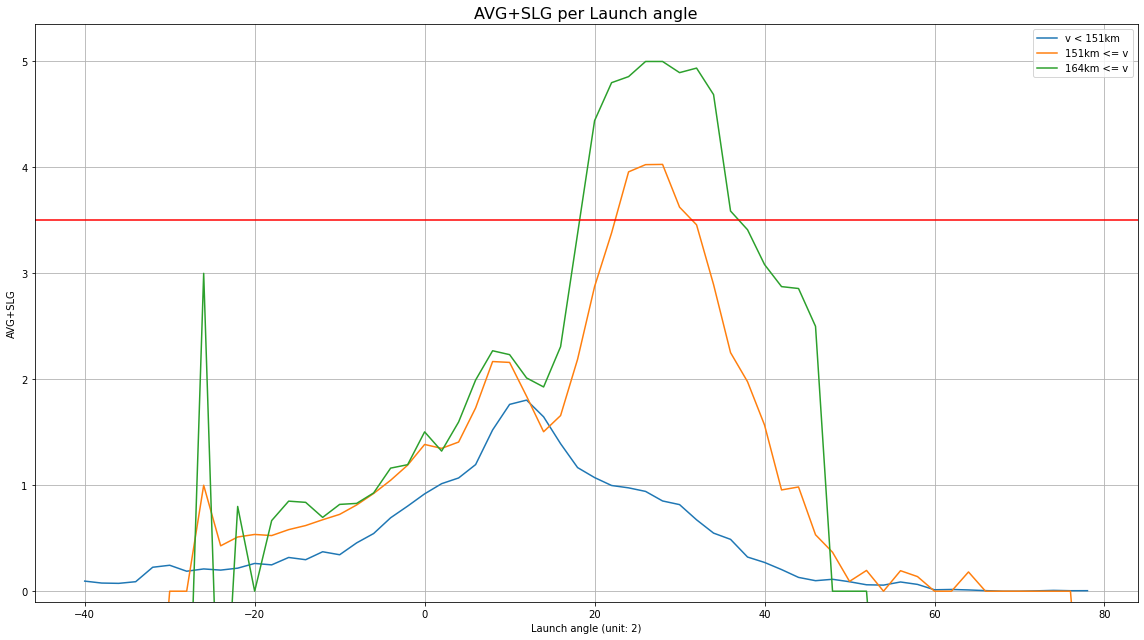

In [14]:
fig = plt.figure(figsize=(16,9))
[plt.plot(ang_range, avg_slg) for avg_slg in AVG_SLGs]
plt.legend(f'v < {vel_pivot[0]}km,{vel_pivot[0]}km <= v,{vel_pivot[1]}km <= v'.split(','))
plt.title('AVG+SLG per Launch angle', fontsize=16)
plt.xlabel(f'Launch angle (unit: {ang_unit})')
plt.ylabel('AVG+SLG')
plt.axhline(3.5, color='r')
plt.ylim(bottom=-0.1)
plt.grid()
plt.tight_layout()
plt.show()

In [15]:
df1 = df1[df1.AVG_SLG > 3.5]
df2 = df2[df2.AVG_SLG > 3.5]
print(vel_pivot[0], df1.ANG_RANGE.min(), df1.ANG_RANGE.max())
print(vel_pivot[1], df2.ANG_RANGE.min(), df2.ANG_RANGE.max())

151 24.0 30.0
164 20.0 36.0


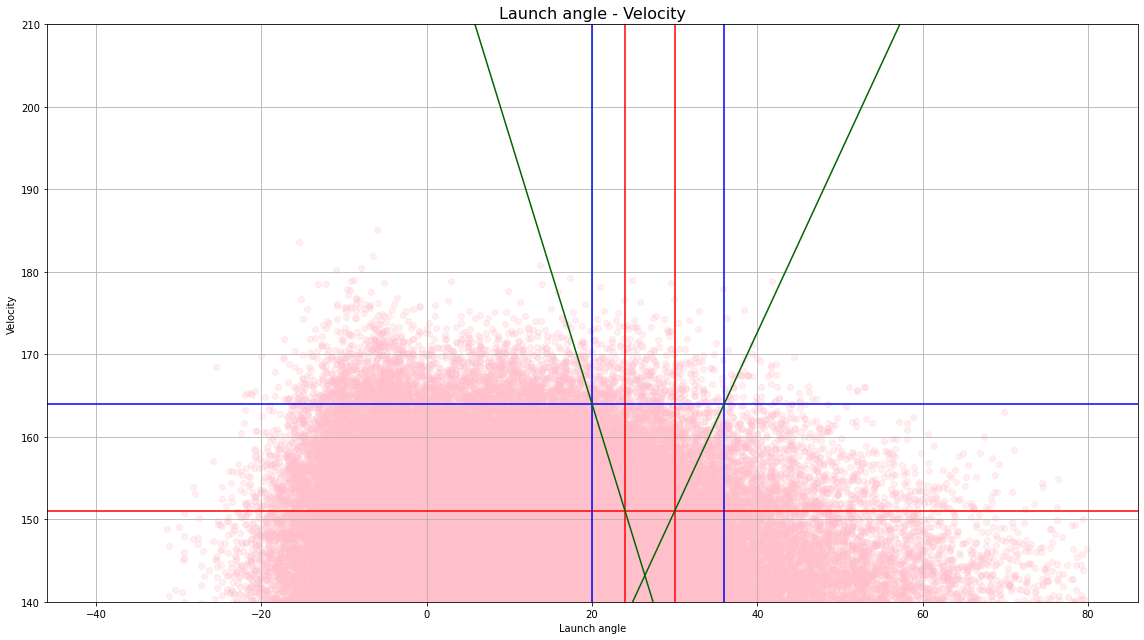

In [16]:
fig = plt.figure(figsize=(16,9))
plt.grid()
plt.scatter(dfHTS.HIT_ANG_VER, dfHTS.HIT_VEL, c='pink', alpha=0.25)
plt.axhline(vel_pivot[0], color='r')
plt.axvline(df1.ANG_RANGE.min(), color='r')
plt.axvline(df1.ANG_RANGE.max(), color='r')
plt.axhline(vel_pivot[1], color='b')
plt.axvline(df2.ANG_RANGE.min(), color='b')
plt.axvline(df2.ANG_RANGE.max(), color='b')
plt.xlabel('Launch angle')
plt.ylabel('Velocity')
plt.title('Launch angle - Velocity', fontsize=16)
line1 = plt.axline((df1.ANG_RANGE.min(), vel_pivot[0]), (df2.ANG_RANGE.min(), vel_pivot[1]), color='darkgreen')
line2 = plt.axline((df1.ANG_RANGE.max(), vel_pivot[0]), (df2.ANG_RANGE.max(), vel_pivot[1]), color='darkgreen')
#plt.axvline(0, color='lime')
#plt.axvline(50, color='lime')
plt.ylim(140, 210)
plt.tight_layout()
plt.show()

In [17]:
def getLineSlopeAndIntercept(p1, p2):
    if type(p1) is not tuple and type(p2) is not tuple:
        return -1
    slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
    intercept = p1[1] - (slope * p1[0])
    return (slope, intercept)

mb1 = getLineSlopeAndIntercept((df1.ANG_RANGE.min(), vel_pivot[0]), (df2.ANG_RANGE.min(), vel_pivot[1]))
mb2 = getLineSlopeAndIntercept((df1.ANG_RANGE.max(), vel_pivot[0]), (df2.ANG_RANGE.max(), vel_pivot[1]))
print(mb1, mb2)

(-3.25, 229.0) (2.1666666666666665, 86.0)


In [18]:
'''
y : velocity
x : angle

y = ax+b
ax = y-b
x = (y-b)/a
'''
print(f'Line-1 : y = {round(mb1[0],5)}x + {round(mb1[1],5)}')
print(f'Line-2 : y = {round(mb2[0],5)}x + {round(mb2[1],5)}')
print(f'x = (y - {round(mb1[1],5)}) / {round(mb1[0], 5)}')
print(f'x = (y - {round(mb2[1],5)}) / {round(mb2[0], 5)}')

Line-1 : y = -3.25x + 229.0
Line-2 : y = 2.16667x + 86.0
x = (y - 229.0) / -3.25
x = (y - 86.0) / 2.16667


In [19]:
# Test
# when velocity 160km
y = 160
x1 = (y - mb1[1]) / mb1[0]
x2 = (y - mb2[1]) / mb2[0]
# if launch angle between x1 and x2, it's barrel
print(x1, x2)

21.23076923076923 34.15384615384615


In [20]:
print(tuple(map(lambda x: round(x, 5), mb1)))
print(tuple(map(lambda x: round(x, 5), mb2)))

(-3.25, 229.0)
(2.16667, 86.0)


In [21]:
def getBarrel(df):
    bound = ((-3.25, 229.0), (2.16667, 86.0))
    a = (df.HIT_VEL - bound[0][1]) / bound[0][0]
    b = (df.HIT_VEL - bound[1][1]) / bound[1][0]
    return df.HIT_ANG_VER.between(a, b)

t_df = origin.copy()
t_df['HIT_BARREL'] = getBarrel(t_df)
len(t_df[t_df.HIT_BARREL]) / len(t_df)

t_df.to_csv('./data/2021_BigContest_KBO_HTS_Merged.csv', index=False, encoding='CP949')

In [22]:
dfHTS = pd.read_csv('./data/2021_BigContest_KBO_HTS_Merged.csv', encoding='CP949', thousands=',')
# TODO: adding a code for pre-processing 'dfPR' (integrating all data, calculating OBP, OPS, mapping NAME, AGE_VA)
dfPR = pd.read_csv('./data/2021_BigContest_KBO_PlayerRecord_Merged.csv', encoding='CP949', thousands=',')
dfHTS = dfHTS[dfHTS.HIT_BARREL]
grouped_dfHTS = dfHTS.groupby('PCODE')
for hts in grouped_dfHTS:
    pcode, df1 = hts
    for y in range(4):
        barrel_count = df1[df1.GYEAR == (2018+y)].HIT_BARREL.count()
        df2 = dfPR.loc[(dfPR.GYEAR == (2018+y)) & (dfPR.PCODE == pcode)]
        dfPR.loc[(dfPR.GYEAR == (2018+y)) & (dfPR.PCODE == pcode), ['BARREL', 'BARREL%']] = (barrel_count, round(barrel_count / df2.AB, 5))

dfPR.to_csv('./data/2021_BigContest_KBO_PlayerRecord_Merged.csv', index=False, encoding='CP949')

c:\users\youngman\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [23]:
da = dfPR.dropna()
print(f'before dropna : {len(dfPR)}')
print(f'after dropna : {len(da)}')

before dropna : 871
after dropna : 745


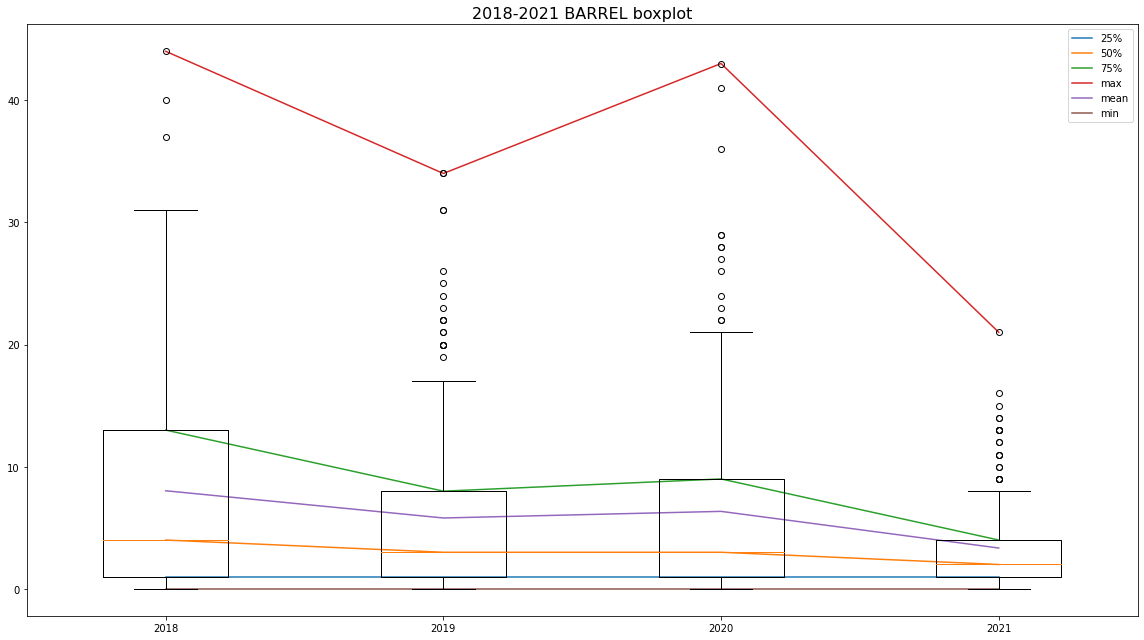

In [24]:
gda = da[da.AB > 15].groupby('GYEAR')

b_stat = []
fig = plt.figure(figsize=(16,9))
for _, df in gda:
    b_stat.append(df.loc[:, 'BARREL'].describe())

keys = b_stat[0].keys().difference(['count', 'std'])
for k in keys:
    plt.plot(range(1, len(b_stat)+1), [b.loc[k] for b in b_stat])
plt.legend(keys)
plt.boxplot([df['BARREL'] for _, df in gda], labels=range(2018, 2021+1))
plt.title('2018-2021 BARREL boxplot', fontsize=16)
plt.tight_layout()
plt.show()

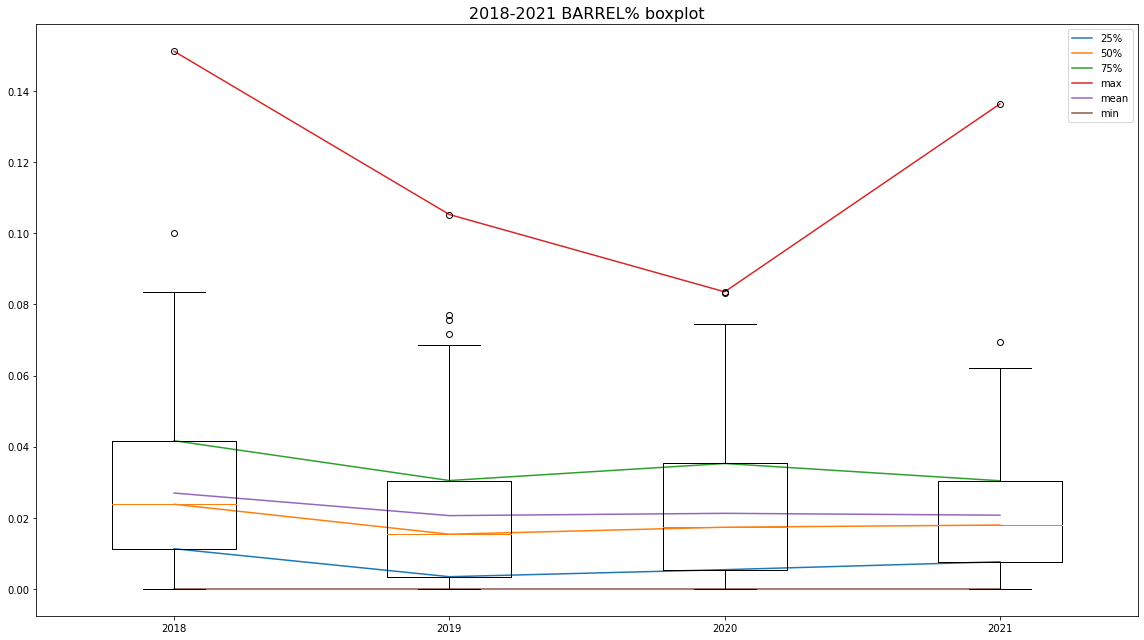

In [25]:
bp_stat = []
fig = plt.figure(figsize=(16,9))
for _, df in gda:
    bp_stat.append(df.loc[:, 'BARREL%'].describe())

keys = bp_stat[0].keys().difference(['count', 'std'])
for k in keys:
    plt.plot(range(1, len(b_stat)+1), [b.loc[k] for b in bp_stat])
plt.legend(keys)
plt.boxplot([df['BARREL%'] for _, df in gda], labels=range(2018, 2021+1))
plt.title('2018-2021 BARREL% boxplot', fontsize=16)
plt.tight_layout()
plt.show()

In [26]:
da.head()

,GYEAR,PCODE,GAMENUM,PA,AB,BA,HIT,HR,TOTB,SLG,...,KK,IB,HP,GD,NAME,AGE_VA,OBP,OPS,BARREL,BARREL%
0,2018,60100,70,169,152,0.243,37,3,63,0.414,...,36,0,4,5,백창수,30,0.313609,0.727609,6.0,0.03947
1,2018,60343,83,174,162,0.216,35,8,63,0.389,...,49,0,3,3,이해창,31,0.265896,0.654896,2.0,0.01235
2,2018,60523,91,194,174,0.305,53,7,86,0.494,...,39,1,1,4,정훈,30,0.360825,0.854825,8.0,0.04598
3,2018,60558,128,374,342,0.254,87,12,144,0.421,...,92,0,4,7,오태곤,26,0.309973,0.730973,8.0,0.02339
5,2018,60605,56,87,76,0.263,20,1,29,0.382,...,12,0,0,2,홍재호,31,0.333333,0.715333,1.0,0.01316
